# **SEP TUTORIAL (astropy.io.fits version)**

### Setup

In [1]:
import numpy as np                                # importing numpy and sep libraries
import sep

from astropy.io import fits                       # FITS handling
from astropy.utils.data import download_file 

import matplotlib.pyplot as plt                   # plotting
from matplotlib import rcParams

%matplotlib inline

rcParams["figure.figsize"] = [10.0, 8.0]


### Background Subtraction

The original SEP tutorial reads a 2D test image from a FITS file using fitsio, so this is going to do the same thing but with astropy.io.fits.
(the image used is image.fits from the SEP GitHub repository (it was kind of buried))

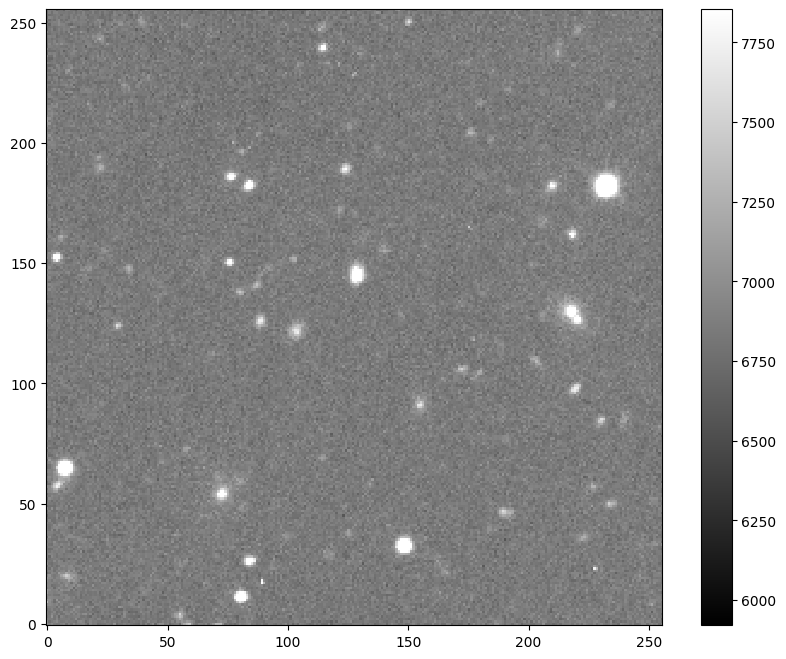

In [32]:
data = fits.getdata("https://github.com/sep-developers/sep/raw/refs/heads/main/data/image.fits")
data = np.ascontiguousarray(data.astype(np.float32))
m,s = np.mean(data), np.std(data)                                                          # this shows the image
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("raw_image.png", dpi=300)   # saving figure (not part of tutorial)

As explained in the original tutorial, most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [6]:
bkg = sep.Background(data)         # this measures a spatially vvarying background on the image

There are various options to control the box size and filtering when estimating the background, and its also possible to mask pixels. An example of this is commented below (but it's just an example so I won't actually be running it here)

In [9]:
# bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)    # remove the comment # to test example

In [10]:
# get a "global" mean and nosie of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [37]:
# evaluate background as 2D array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg)        # equivalent to above

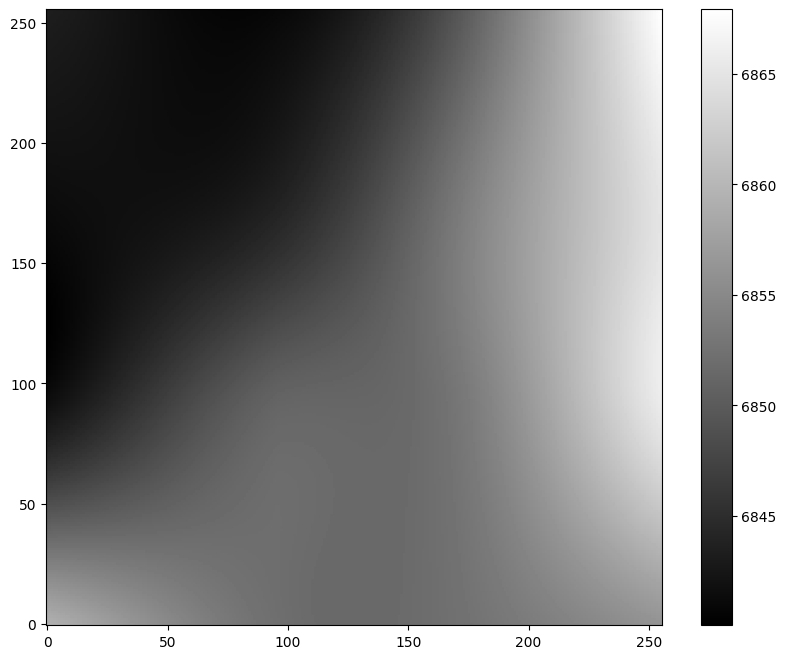

In [34]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("background_map.png", dpi=300)    # saving figure (not part of tutorial)

In [15]:
# evalute the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

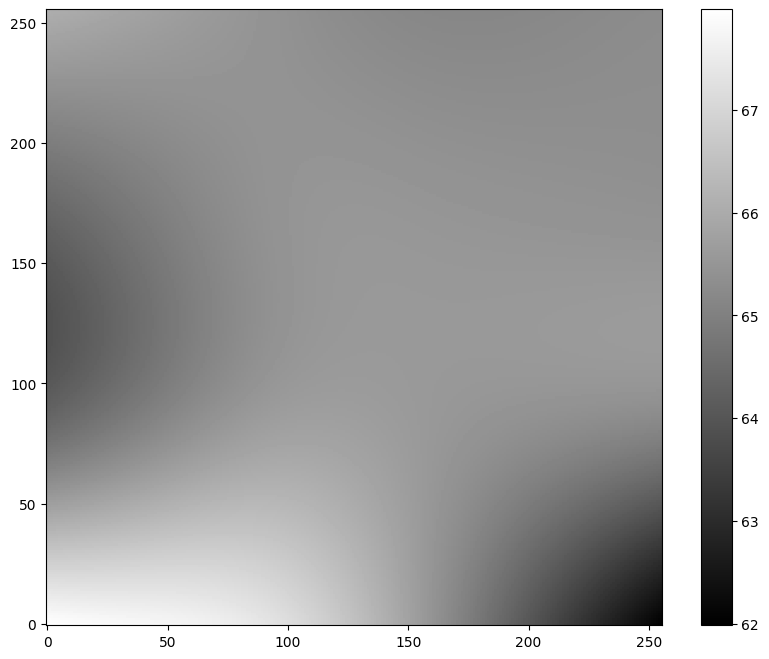

In [35]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("background_rms.png", dpi=300)   # saving figure (not part of tutorial)

In [20]:
# subtract the background
data_sub = data - bkg          # You can also subtract the background from the data array with bkg.subfrom(data)

### Object Detection

Now that the background has been subtracted, you can run object detection on the background subtracted image, and since background noise is pretty flat, we can set a detection threshold to be a constant value of 1.5σ where σ is the global background RMS.

In [21]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

sep.extract has many options for controlling detection treshold, pixel masking, filtering, and object deblending. The result 'objects' is a NumPy structured array with many fields.

In [22]:
# how many objects were detected
len(objects)

69

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we'll over-plot the object coordinates with some basic shape parameters on the image

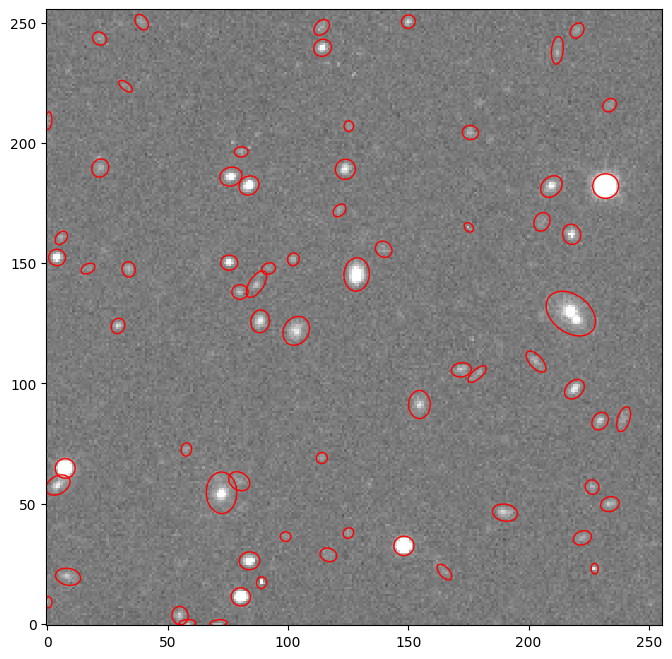

In [36]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180.0 / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

    plt.savefig("background_subtracted.png", dpi=300) # saving figure (not part of tutorial)

objects has many other fields, giving information such as second moments, and peak pixel positions and values

In [25]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Aperture Photometry

Finally, we'll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [27]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
# flux, fluxerr and flag are all 1-D arrays with one entry per object

In [30]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} =/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 =/- 291.027802
object 1: flux = 3092.220430 =/- 291.592204
object 2: flux = 5949.868379 =/- 356.562003
object 3: flux = 1851.426582 =/- 295.028816
object 4: flux = 72736.386914 =/- 440.172206
object 5: flux = 3860.756152 =/- 352.163162
object 6: flux = 6418.913789 =/- 357.458973
object 7: flux = 2210.707656 =/- 350.791223
object 8: flux = 2741.607227 =/- 352.277746
object 9: flux = 20916.875566 =/- 376.966138
